## 2. Exploratory Data Analysis

Kernel used audio8_2_tf \
see audio8_2_tf_requirements.txt for the requirements

## To Run 

Requires the preprocessing files
* the one second samples in \sample_output_directory\
* the DataFrame pickle file with file data and metadata

## Imports


In [86]:
import librosa
from pydub import AudioSegment
import soundfile as sf
import ffmpeg
from IPython.display import Audio

In [87]:
import pandas as pd
import numpy as np
import os

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
librosa.__version__

'0.10.2.post1'

## File inputs and GLOBAL VARIABLES

In [11]:
#file_class=pd.read_csv('file_class.csv',index_col=0) #"C:\Users\GGMachines_Gaming\Documents\voxpop\file_class.df"

In [9]:
CWD=os.getcwd()
print(CWD)

C:\Users\GGMachines_Gaming\Documents\voxpop


In [17]:
INPUT_DIRECTORY=CWD+"\\sample_output_directory\\"

In [10]:
#INPUT_DIRECTORY='C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\' #i9 machine

In [18]:
INPUT_DIRECTORY

'C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\'

In [12]:
TRAIN_TEST_SPLIT = 0.80

In [13]:
EPOCHS=30
BATCH_SIZE=32

In [42]:
#dub_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0000_DUB_features.pkl') 
#i9 directory absolute location

In [91]:
#antbel_df = pd.read_pickle('C:\\Users\\GGMachines_Gaming\\Documents\\voxpop\\sample_output_directory\\20240721_0013_ANT_features.pkl') 
#i9 directory absolute location

In [92]:
dub_df = pd.read_pickle(INPUT_DIRECTORY+'20240721_0000_DUB_features.pkl')

In [93]:
antbel_df = pd.read_pickle(INPUT_DIRECTORY+'20240721_0013_ANT_features.pkl') #i9 directory

## Recording counts 

In [22]:
recordings_dub=dub_df['recording num'].max()
recordings_dub

166

In [23]:
recordings_antbel=antbel_df['recording num'].max()
print(recordings_antbel)

65


In [27]:
print("Recordings")
print("Dublin = {:.0f}".format(recordings_dub))
print("Antrim and Belfast = {:0f}".format(recordings_antbel) )
print("total = {:.0f}".format(recordings_dub+recordings_antbel) )

Recordings
Dublin = 166
Antrim and Belfast = 65.000000
total = 231


In [25]:
#Increase the recording number in the 2nd dataframe so that there are no duplicates
antbel_df['recording num']=dub_df['recording num']+recordings_dub
antbel_df['recording num']

0       166
1       166
2       166
3       166
4       166
       ... 
6489    237
6490    237
6491    237
6492    237
6493    237
Name: recording num, Length: 6494, dtype: object

## Merge the DataFrames

In [28]:
# Concatenate the DataFrames
all_df= pd.concat([antbel_df, dub_df], ignore_index=True)

In [29]:
all_df.shape

(21594, 18)

In [30]:
all_df[0:3]

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,1,ANT_Antrim_R1_F_20_Rec_0_Sample_1.wav,"[-0.063719966, 0.018594107, 0.042440787, 0.011...","[[-24.939114, -19.037073, -35.540073, -40.6882...",22050,"[[-200.87267, -189.22813, -205.93425, -217.350...","[[1.7263998, 1.7263998, 1.7263998, 1.7263998, ...","[[8.442614, 8.442614, 8.442614, 8.442614, 8.44..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,2,ANT_Antrim_R1_F_20_Rec_0_Sample_2.wav,"[-0.009588398, -0.029184137, -0.023096263, -0....","[[-12.003866, -22.771717, -25.912066, -27.5487...",22050,"[[-269.9958, -209.71855, -199.9971, -192.51334...","[[7.1880474, 7.1880474, 7.1880474, 7.1880474, ...","[[-7.412616, -7.412616, -7.412616, -7.412616, ..."


In [31]:
#take one value, the first, from every set of samples
recordings_df = all_df[all_df['sample num'] == 0]

# Drop duplicates to ensure each recording appears only once
recordings_df = recordings_df.drop_duplicates(subset=['recording num'])

# Reset the index for the new DataFrame
recordings_df.reset_index(drop=True, inplace=True)

In [32]:
recordings_df.shape

(230, 18)

In [34]:
recordings_df

,filenames,names,counties,towns,urbanrural,size,genders,ages,dur,recording num,sample num,sample file name,sample,Ydb,sr,mfcc,mfcc_delta,mfcc_delta_2
0,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_F_20,ANT,Antrim,R,1,F,20,95.95,166,0,ANT_Antrim_R1_F_20_Rec_0_Sample_0.wav,"[-3.259629e-09, -1.9790605e-09, -1.8626451e-09...","[[-35.601192, -23.076942, -25.175114, -30.8771...",22050,"[[-494.3632, -314.76587, -256.5209, -248.23921...","[[22.54509, 22.54509, 22.54509, 22.54509, 22.5...","[[-13.363751, -13.363751, -13.363751, -13.3637..."
1,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_M_25,ANT,Antrim,R,1,M,25,116.04,167,0,ANT_Antrim_R1_M_25_Rec_1_Sample_0.wav,"[-3.2014214e-10, -5.820766e-11, -1.4551915e-10...","[[-33.160713, -16.867645, -14.588329, -21.9429...",22050,"[[-567.5135, -404.5886, -353.5435, -344.66907,...","[[51.188786, 51.188786, 51.188786, 51.188786, ...","[[-0.2170428, -0.2170428, -0.2170428, -0.21704..."
2,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_A...,ANT_Antrim_R1_M_40,ANT,Antrim,R,1,M,40,133.02,168,0,ANT_Antrim_R1_M_40_Rec_2_Sample_0.wav,"[-5.820766e-10, -9.895302e-10, -9.313226e-10, ...","[[-45.422356, -37.79415, -29.457226, -19.70018...",22050,"[[-548.9338, -374.04187, -307.50232, -262.8846...","[[41.07573, 41.07573, 41.07573, 41.07573, 41.0...","[[-26.089209, -26.089209, -26.089209, -26.0892..."
3,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_B...,ANT_Ballycastle_R1_F_70,ANT,Ballycastle,R,1,F,70,117.86,170,0,ANT_Ballycastle_R1_F_70_Rec_3_Sample_0.wav,"[1.1641532e-10, -2.910383e-11, -1.1641532e-10,...","[[-42.212063, -36.867523, -47.102856, -47.1028...",22050,"[[-642.2097, -505.1154, -389.91708, -297.05542...","[[38.775097, 38.775097, 38.775097, 38.775097, ...","[[-16.443972, -16.443972, -16.443972, -16.4439..."
4,C:\Users\GGMachines_Gaming\Documents\ANT\ANT_B...,ANT_Ballycastle_R1_M_25,ANT,Ballycastle,R,1,M,25,126.07,171,0,ANT_Ballycastle_R1_M_25_Rec_4_Sample_0.wav,"[0.0, 3.4924597e-10, -1.7462298e-10, -6.693881...","[[-34.074398, -19.373589, -21.229664, -26.9904...",22050,"[[-578.94977, -416.94687, -356.12296, -347.986...","[[58.174633, 58.174633, 58.174633, 58.174633, ...","[[-14.451537, -14.451537, -14.451537, -14.4515..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_T...,DUB_Terenure_M_20,DUB,Terenure,None,None,M,20,103.31,161,0,DUB_Terenure_M_20_Rec_161_Sample_0.wav,"[0.0, -9.313226e-10, -2.3283064e-10, -1.164153...","[[-27.474337, -15.680954, -21.35504, -37.55080...",22050,"[[-481.27567, -314.43658, -239.3003, -169.3499...","[[29.3374, 29.3374, 29.3374, 29.3374, 29.3374,...","[[-33.328503, -33.328503, -33.328503, -33.3285..."
226,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_T...,DUB_Terenure_M_20_(2),DUB,Terenure,None,None,M,20,113.89,162,0,DUB_Terenure_M_20_(2)_Rec_162_Sample_0.wav,"[1.8626451e-09, 5.820766e-10, 1.0477379e-09, -...","[[-24.561527, -18.126556, -20.174446, -24.9668...",22050,"[[-494.13116, -344.05396, -286.59027, -222.733...","[[41.57098, 41.57098, 41.57098, 41.57098, 41.5...","[[-25.27901, -25.27901, -25.27901, -25.27901, ..."
227,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_T...,DUB_Terenure_M_30,DUB,Terenure,None,None,M,30,94.82,163,0,DUB_Terenure_M_30_Rec_163_Sample_0.wav,"[1.7462298e-09, 1.1641532e-09, 0.0, -4.656613e...","[[-37.952183, -23.579098, -21.54805, -24.83200...",22050,"[[-524.10876, -382.91833, -324.70975, -232.242...","[[33.439034, 33.439034, 33.439034, 33.439034, ...","[[-29.519438, -29.519438, -29.519438, -29.5194..."
228,C:\Users\GGMachines_Gaming\Documents\DUB\DUB_W...,DUB_Walkinstown_F_30,DUB,Walkinstown,None,None,F,30,94.82,164,0,DUB_Walkinstown_F_30_Rec_164_Sample_0.wav,"[-2.3283064e-10, 2.3283064e-10, -9.313226e-10,...","[[-28.146809, -18.667927, -25.974913, -16.8746...",22050,"[[-520.7522, -328.3403, -273.99213, -244.34686...","[[17.582151, 17.582151, 17.582151, 17.582151, ...","[[-33.120426, -33.120426, -33.120426, -33.1204..."


# Summary Data Analysis 

### Irish-English accents by location, from Hickey, Sound Atlas of Irish English (2004)

![Irish-English accents by location, from Hickey, Sound Atlas of Irish-English (2004)](accentmap.png)


## Recordings by County

In [35]:
recordings_df['counties'].value_counts()

counties
DUB    166
ANT     38
BEL     26
Name: count, dtype: int64

## As we might expect, Dublin has more speech samples than the Belfast and Antrim region, so the classes are imbalanced

In [76]:
# Calculate the value counts for the counties 
counties_counts = recordings_df['counties'].value_counts()
counties_counts_df = counties_counts.reset_index()
counties_counts_df.columns = ['county', 'count']

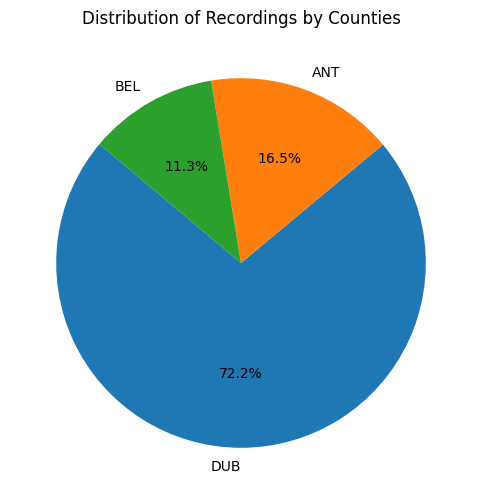

In [77]:
# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(counties_counts, labels=counties_counts.index, autopct='%1.1f%%', startangle=140) 
plt.title('Distribution of Recordings by Counties')
plt.show()

## Speaker age distribution

In [38]:
ages_counts = recordings_df['ages'].value_counts()
ages_counts_df = ages_counts.reset_index()
ages_counts_df.columns = ['ages', 'counts']
sorted_ages_counts_df = ages_counts_df.sort_values(by='ages')
sorted_ages_counts_df.reset_index(drop=True, inplace=True)

print(sorted_ages_counts_df)

    ages  counts
0     15       5
1     16       1
2     20     184
3     25       7
4     30      10
5     35       5
6     40       5
7     45       1
8     50       4
9     55       2
10    60       2
11    65       1
12    70       2
13    80       1


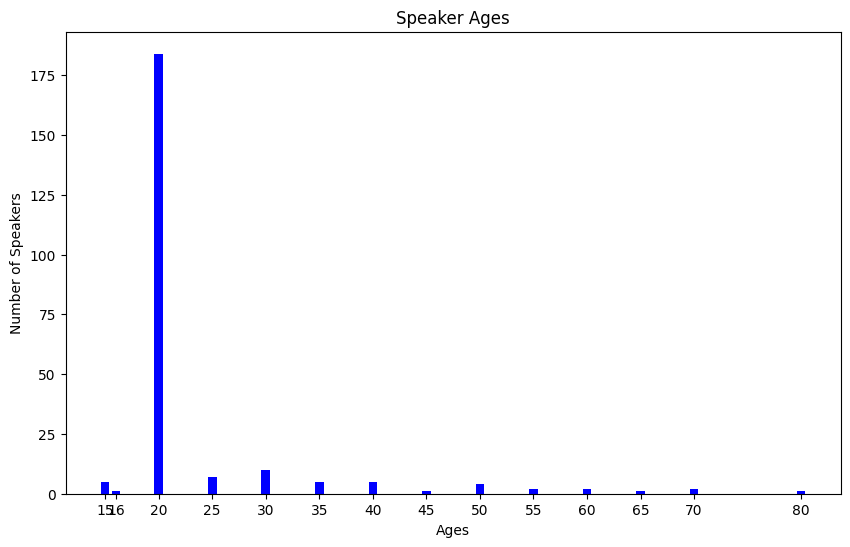

In [44]:
ages = sorted_ages_counts_df['ages']
counts = sorted_ages_counts_df['counts']

plt.figure(figsize=(10, 6))
plt.bar(ages, counts, color='blue')

plt.xlabel('Ages')
plt.ylabel('Number of Speakers')
plt.title('Speaker Ages')

plt.xticks(ticks=ages, labels=ages)

# Display the chart
plt.show()

## Speaker ages by county

In [42]:
recordings_df.groupby('counties')['ages'].value_counts()

counties  ages
ANT       20       18
          25        4
          30        4
          50        2
          55        2
          60        2
          70        2
          16        1
          40        1
          65        1
          80        1
BEL       20       22
          40        2
          30        1
          35        1
DUB       20      144
          15        5
          30        5
          35        4
          25        3
          40        2
          50        2
          45        1
Name: count, dtype: int64

## Speakers estimated at 20 years of age are a majority in every geographic area

## Gender distribution by County

In [81]:
grouped = recordings_df.groupby(['counties', 'genders']).size().reset_index(name='counts')
print(grouped)

  counties genders  counts
0      ANT       F      15
1      ANT       M      23
2      BEL       F       7
3      BEL       M      19
4      DUB       F      86
5      DUB       M      80


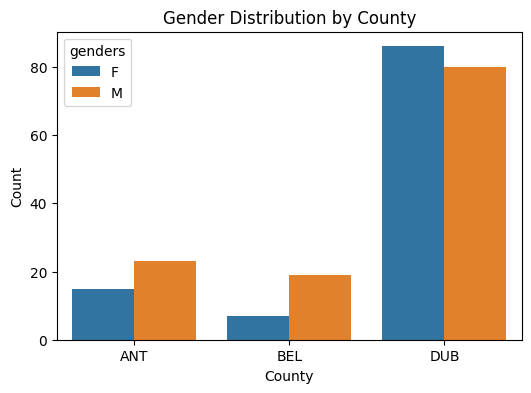

In [46]:
# Create the bar plot
plt.figure(figsize=(6, 4))
sns.barplot(data=grouped, x='counties', y='counts', hue='genders')

# Add title and labels
plt.title('Gender Distribution by County')
plt.xlabel('County')
plt.ylabel('Count')

# Show the plot
plt.show()

## Male speakers outnumber females in total and in Belfast and Antrim, but not  in Dublin,

In [57]:
genders_counts=recordings_df['genders'].value_counts()
genders_counts

genders
M    122
F    108
Name: count, dtype: int64

## Speakers by county and gender

In [53]:
recordings_df.groupby('counties')['genders'].value_counts()

counties  genders
ANT       M          23
          F          15
BEL       M          19
          F           7
DUB       F          86
          M          80
Name: count, dtype: int64

In [56]:
# Calculate the value counts for the counties 
ages_counts = recordings_df.groupby('counties')['genders'].value_counts()
ages_counts_df = ages_counts.reset_index()


## Recordings by town

In [82]:
recordings_df['towns'].value_counts()[0:40]

towns
City            11
Tallaght        10
Blanchard        9
Terenure         7
Dunleary         7
Bray             7
North            6
Templeogue       6
Clontarf         6
Ballymena        5
Swords           5
Clonskea         5
Sandyford        5
Rathfarnham      5
Ballinteer       4
Malahide         4
East             4
Lucan            4
Cabinteely       4
Ballycastle      4
Castleknock      4
Dundrum          4
Ranelagh         4
Rathgar          4
Shankhill        4
Antrim           3
Monkstown        3
Artane           3
Newtownabbey     3
Lisburn          3
Knocklyon        3
Rathmines        3
Ballymoney       3
Churchtown       3
Crumlin          3
Sutton           2
Finglas          2
Foxrock          2
Portmarnock      2
Goatstown        2
Name: count, dtype: int64

In [84]:
recordings_df.groupby('counties')['towns'].value_counts()[0:60]

counties  towns        
ANT       Ballymena         5
          Ballycastle       4
          Antrim            3
          Ballymoney        3
          Lisburn           3
          Newtownabbey      3
          Ballyclare        2
          Crumlin           2
          Larne             2
          Randalstown       2
          Ballynure         1
          Bushmills         1
          Carnlough         1
          Carrickfergus     1
          Cullybackey       1
          Dervock           1
          Dunloy            1
          Glenarm           1
          Templepatrick     1
BEL       City             11
          North             6
          East              4
          South             2
          Drumbeg           1
          OrmeauRoad        1
          Whitehouse        1
DUB       Tallaght         10
          Blanchard         9
          Bray              7
          Dunleary          7
          Terenure          7
          Clontarf          6
          Temple

## Speakers are not very concentrated in particular districts of Dublin
## Biggest category in Belfast dataset is 'city', while no category for the west, the traditional centre for Irish Catholic / Nationalist / Republican communities 